In [47]:
#Load model + modules
import pickle
import sys
sys.path.append("..")
from custom_scripts import preprocessing
from custom_scripts import preparation
from custom_scripts import modeling
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

save_file = open('Binary.pickle', 'rb')
model = pickle.load(save_file)
save_file.close()


In [49]:
#Function for undersampling
def undersampling(X, y):
    # instantiating the random undersampler
    rus = RandomUnderSampler(random_state=42) 
    # resampling X, y
    X_rus, y_rus = rus.fit_resample(X, y)
    # new class distribution
    print(Counter(y_rus))
    return X_rus, y_rus

In [52]:
### Get training data
train_flights = preprocessing.get_train_flights()
train_flights.shape

(287151, 11)

In [51]:
### Get testing data
test_flights = preprocessing.get_test_flights()
X_test = test_flights.copy()
### Convert to string format to make it in line with format of training data
X_test['fl_date'] = X_test['fl_date'].astype(str)
X_test.shape

(150623, 10)

In [53]:
### Build features
train_flights = preparation.build_all_features(train_flights)
X_test = preparation.build_all_features(X_test)
print(f'training data: {train_flights.shape}')
print(f'testing data: {X_test.shape}')

C:\Users\brian\lighthouse-data-notes\Midterm-Project-Lighthouselabs\final_models\..\custom_scripts\preparation.py:168: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  flight_data.drop(['arrival_time','departure_time'],1,inplace=True)
C:\Users\brian\lighthouse-data-notes\Midterm-Project-Lighthouselabs\final_models\..\custom_scripts\preparation.py:185: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  weather_table.drop('AirportCode', 1, inplace= True)


training data: (287151, 47)
testing data: (150623, 46)


In [54]:
# Creating two classes, 0 for on time (or early) within 15 minutes, and 1 for late past 15 minutes.
train_flights.loc[train_flights['arr_delay'] <= 15, 'arr_delay'] = 0
train_flights.loc[train_flights['arr_delay'] > 15, 'arr_delay'] = 1

In [55]:
# Split the Data for validation set and to scale data.
X2 = train_flights.select_dtypes(exclude=['object'])
X = X2.drop(['arr_delay','crs_dep_time','crs_arr_time'],1)
y = train_flights['arr_delay']
X_train, X_val, y_train, y_val = preparation.get_train_test_split(X, y)

C:\Users\brian\AppData\Local\Temp/ipykernel_3656/4204894045.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X2.drop(['arr_delay','crs_dep_time','crs_arr_time'],1)


In [56]:
#Scale the test data
X_train, X_val, X_test = preparation.standardize_data(data_arr=[X_train, X_val, X_test],scaler=StandardScaler())
print(X_train.shape)
print(X_val.shape)
X_train.head(1)

C:\Users\brian\lighthouse-data-notes\Midterm-Project-Lighthouselabs\final_models\..\custom_scripts\preparation.py:89: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  prepared_data_arr.append(pd.concat(segments,1))
C:\Users\brian\lighthouse-data-notes\Midterm-Project-Lighthouselabs\final_models\..\custom_scripts\preparation.py:89: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  prepared_data_arr.append(pd.concat(segments,1))


(201005, 42)
(86146, 42)


C:\Users\brian\lighthouse-data-notes\Midterm-Project-Lighthouselabs\final_models\..\custom_scripts\preparation.py:89: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  prepared_data_arr.append(pd.concat(segments,1))


,arr_time_sin,arr_time_cos,dep_time_sin,dep_time_cos,fl_num_avg_arr_delay,fl_num_avg_dep_delay,fl_num_avg_late_aircraft_delay,fl_num_avg_taxi_out,tail_num_avg_arr_delay,tail_num_avg_dep_delay,...,dest_rain,dest_snow,dest_storm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
168275,-0.261103,-0.965311,0.089391,-0.995997,0.390643,-0.491667,0.032987,1.376622,-0.033406,-0.720895,...,-0.689118,-0.278881,-0.079582,0,1,0,0,0,0,0


In [57]:
X_train, y_train = undersampling(X_train, y_train)

Counter({0.0: 35258, 1.0: 35258})


{'f1_score': 0.4150496827242864, 'recall_score': 0.6668196420376319, 'precision_score': 0.3012915457076841, 'accuracy_score': 0.6672045132681726}


RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=280, random_state=0)

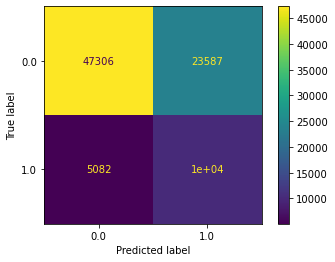

In [58]:
from sklearn.ensemble import RandomForestClassifier #Pickle27 modified
model = RandomForestClassifier(n_estimators = 280, max_depth=70, max_features = 'auto', min_samples_leaf= 4, min_samples_split = 4, random_state=0)
notes = "NO, RFC after gridsearch, n_estimators = 280, max_depth=70, max_features = 'auto', min_samples_leaf= 4, min_samples_split = 4, stand, dsamp"
modeling.run_test(X_train,X_val,y_train,y_val, model, notes)

In [59]:
predictions = model.predict(X_test)

test_flights['arr_delay'] = predictions
test_flights.to_csv('../final_binary_predictions.csv')

In [60]:
#Save as pickle
save_file = open('Binary.pickle', 'wb')
pickle.dump(model,save_file)